# Information Robust Dirichlet Networks


In this notebook, we implement the specialized training loss proposed in the paper _Information Robust Dirichlet Networks for Predictive Uncertainty Estimation_ by Tsiligkaridis (2019). The method models predictive uncertainty by having a neural network output Dirichlet concentration parameters 𝛼 instead of just a pointwise softmax.

The total loss is composed of three terms:

1. Calibration term: implemented in the function  lp_fn
2. Regularization term: implemented in the function  regularization_fn
3. Adversiarial Entropy penalty: implemented in the function  dirichlet_entropy

In the paper and in this notenbook, L_p loss is not directly computed but rather an upper bound for it, denoted by F_i (for sample i)  

The regularization term penalizes high alpha values for incorrect classes.  

The final term uses the alpha values the model assigns to adversarial inputs.
The model is rewarded for outputting a Dirichlet-distribution with high entropy on these inputs.

### 1. The Loss

In [ ]:
from __future__ import annotations

import torch
from torch.special import digamma


def lp_fn(alpha: torch.Tensor, y: torch.Tensor, p: float = 2.0) -> torch.Tensor:
    """Compute the Lp calibration loss (upper bound Fi).

    Computes F_i using the expectation-based formulation:
        F_i = ( E[(1-p_c)^p] + Σ_{j≠c} E[p_j^p] )^(1/p)

    Args:
        alpha: Dirichlet concentration parameters, shape (B, K), must be > 0
        y: One-hot encoded labels, shape (B, K)
        p: Lp norm exponent (default: 2.0)

    Returns:
        Scalar loss summed over batch

    Raises:
        ValueError: If alpha contains non-positive values or shapes don't match
    """
    if not torch.all(alpha > 0):
        msg = f"All alpha values must be > 0, got min={alpha.min().item()}"
        raise ValueError(msg)

    if alpha.shape != y.shape:
        msg = f"alpha and y shape mismatch: {alpha.shape} vs {y.shape}"
        raise ValueError(msg)

    B, K = alpha.shape  # noqa: N806

    # total concentration alpha0
    alpha0 = alpha.sum(dim=1, keepdim=True)  # (B,1)

    # extract alpha_c (correct class)
    alpha_c = (alpha * y).sum(dim=1, keepdim=True)  # (B,1)
    alpha0_minus_c = alpha0 - alpha_c  # (B,1)

    # log B(a,b) used for expectations: E[X^p] = B(a+p,b)/B(a,b)
    def log_b(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
        return torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a + b)

    # E[(1 - p_c)^p]   where (1 - p_c) ~ Beta( alpha0 - alpha_c , alpha_c )
    log_e1 = log_b(alpha0_minus_c + p, alpha_c) - log_b(alpha0_minus_c, alpha_c)
    e1 = torch.exp(log_e1)  # (B,1)

    # Per-class E[p_j^p] for all j
    log_ep = log_b(alpha + p, alpha0 - alpha) - log_b(alpha, alpha0 - alpha)
    ep = torch.exp(log_ep)

    # zero-out the true class term so we sum only j≠c
    ep = ep * (1 - y)

    # final expectation sum
    e_sum = e1 + ep.sum(dim=1, keepdim=True)  # (B,1)

    # apply ^(1/p)  # noqa: ERA001
    fi = torch.exp(torch.log(e_sum + 1e-8) / p).squeeze(1)  # (B,)

    return fi.sum()


def regularization_fn(alpha: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Compute the regularization term using trigamma functions.

    Penalizes high alpha values for incorrect classes to encourage confident
    but calibrated predictions.

    Args:
        alpha: Dirichlet concentration parameters, shape (B, K), must be > 0
        y: One-hot encoded labels, shape (B, K)

    Returns:
        Scalar regularization loss

    Raises:
        ValueError: If shapes don't match
    """
    if alpha.shape != y.shape:
        msg = f"alpha and y shape mismatch: {alpha.shape} vs {y.shape}"
        raise ValueError(msg)

    # Build alpha_tilde by replacing correct-class alpha with 1
    alpha_tilde = alpha * (1 - y) + y

    # Compute alpha_tilde_0 = 1 + sum over incorrect classes
    alpha_tilde_0 = torch.sum(alpha_tilde, dim=1, keepdim=True)

    # Polygamma(1, x) = trigamma(x)
    trigamma_alpha = torch.polygamma(1, alpha_tilde)
    trigamma_alpha0 = torch.polygamma(1, alpha_tilde_0)

    # (alpha_tilde - 1)^2 term
    diff_sq = (alpha_tilde - 1.0) ** 2

    # Penalty only for incorrect classes → mask out true class
    mask = 1 - y

    # Compute elementwise contribution
    term = 0.5 * diff_sq * (trigamma_alpha - trigamma_alpha0) * mask

    # Sum over classes and batch
    return torch.sum(term)


def dirichlet_entropy(alpha: torch.Tensor) -> torch.Tensor:
    """Compute Dirichlet entropy.

    For adversarial examples, we want to maximize entropy (reward the model for
    being uncertain), which appears as a negative term in the loss.

    Entropy formula (a stands for alpha):
        H(a) = log B(a) + (a_0 - K) * ψ(a_0) - Σ_k (a_k - 1) * ψ(a_k)

    Args:
        alpha: Dirichlet concentration parameters, shape (B_a, K), must be > 0

    Returns:
        Scalar entropy summed over batch

    Raises:
        ValueError: If alpha contains non-positive values
    """
    if not torch.all(alpha > 0):
        msg = f"All alpha values must be > 0, got min={alpha.min().item()}"
        raise ValueError(msg)

    K = alpha.size(-1)  # noqa: N806
    alpha0 = alpha.sum(dim=-1)

    log_b = torch.lgamma(alpha).sum(dim=-1) - torch.lgamma(alpha0)

    term1 = log_b
    term2 = (alpha0 - K) * digamma(alpha0)
    term3 = ((alpha - 1) * digamma(alpha)).sum(dim=-1)
    entropy = term1 + term2 - term3

    return entropy.sum()


def loss_IRD(  # noqa: N802
    alpha: torch.Tensor,
    y: torch.Tensor,
    adversarial_alpha: torch.Tensor | None = None,
    p: float = 2.0,
    lam: float = 1.0,
    gamma: float = 1.0,
    normalize: bool = True,
) -> torch.Tensor:
    """Compute the Loss introduced in paper: Information Robust Dirichlet Networks for Predictive Uncertainty Estimation
    Args:
        alpha : (B, K) Dirichlet concentration parameters
        adversarial_alpha : (B_a, K) adversarial_alpha concentration parameters for adversarial inputs
        y     : (B, K) one-hot labels
        p     : scalar exponent
    Returns:
        loss_IRD : the IRD loss comprised of all three terms, summed over all input examples.
    """  # noqa: D205
    # Input validation
    if alpha.dim() != 2 or y.dim() != 2:
        msg = f"alpha and y must be 2D, got {alpha.dim()}, {y.dim()}"
        raise ValueError(msg)

    if alpha.shape != y.shape:
        msg = f"alpha and y shape mismatch: {alpha.shape} vs {y.shape}"
        raise ValueError(msg)

    if not torch.all(alpha > 0):
        msg = f"All alpha values must be > 0, got min={alpha.min().item()}"
        raise ValueError(msg)

    # Compute Loss Components
    lp_term = lp_fn(alpha, y, p)
    reg_term = regularization_fn(alpha, y)

    if adversarial_alpha is not None:
        if adversarial_alpha.dim() != 2:
            msg = f"adversarial_alpha must be 2D, got {adversarial_alpha.dim()}"
            raise ValueError(msg)

        if adversarial_alpha.shape[1] != alpha.shape[1]:
            msg = (
                f"adversarial_alpha must have same number of classes as alpha: "
                f"{adversarial_alpha.shape[1]} vs {alpha.shape[1]}"
            )
            raise ValueError(
                msg,
            )

        entropy_term = dirichlet_entropy(adversarial_alpha)
    else:
        entropy_term = 0.0

    # Normalize by batch sizes for stable training across different batch sizes
    if normalize:
        B = alpha.shape[0]  # noqa: N806
        K = alpha.shape[1]  # noqa: N806
        lp_term = lp_term / B
        reg_term = reg_term / (B * K)

        if adversarial_alpha is not None and isinstance(entropy_term, torch.Tensor):
            B_a = adversarial_alpha.shape[0]  # noqa: N806
            entropy_term = entropy_term / B_a

    loss = lp_term + lam * reg_term - gamma * entropy_term

    return loss

### 2. Testing

Let´s also test our loss by implementing a simple Evidential CNN for grayscale MNIST images. Here is the setup:



In [ ]:
"""Setup training pipeline with MNIST, ResNet18, and AdamW optimizer."""
from __future__ import annotations  # noqa: E402, F404

import torch  # noqa: E402, F811
from torch import nn  # noqa: E402
import torch.nn.functional as F  # noqa: E402, F401
from torch.utils.data import DataLoader  # noqa: E402
from torchvision import datasets, transforms  # noqa: E402
from tqdm import tqdm  # noqa: E402


def get_mnist_dataloaders(
    batch_size: int = 32,
    num_workers: int = 0,
    data_dir: str = "./data",
) -> tuple[DataLoader, DataLoader]:
    """Load MNIST dataset and create training and validation dataloaders.

    Args:
        batch_size: Batch size for dataloaders (default: 32)
        num_workers: Number of workers for data loading (default: 0)
        data_dir: Directory to store MNIST data (default: "./data")

    Returns:
        Tuple of (train_loader, val_loader)
    """
    # Define transforms for MNIST - keep grayscale (1 channel)
    transform_train = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.1307],  # MNIST mean
                std=[0.3081],  # MNIST std
            ),
        ],
    )

    transform_val = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.1307],
                std=[0.3081],
            ),
        ],
    )

    # Load training dataset
    train_dataset = datasets.MNIST(
        root=data_dir,
        train=True,
        download=True,
        transform=transform_train,
    )

    # Load validation dataset (using test set as validation)
    val_dataset = datasets.MNIST(
        root=data_dir,
        train=False,
        download=True,
        transform=transform_val,
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_loader, val_loader

The CNN is composed of three layers, whereas the outputs of these layers are being transformed into alpha values (applying ReLU and then adding 1 instead of softmax) for evidential learning. 

In [7]:
class GrayscaleMNISTCNN(nn.Module):
    """Simple Evidential CNN for grayscale MNIST images.
    Returns Dirichlet parameters (alpha) as output.
    """  # noqa: D205

    def __init__(self, num_classes: int = 10) -> None:
        """Initialize the CNN."""
        super().__init__()
        # (batch, 1, 28, 28) -> (batch, 32, 28, 28)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU(inplace=True)

        # After 3 pooling layers: 28 -> 14 -> 7 -> 3 (with padding)
        # Actual: 28 -> 14 -> 7 -> 3
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # 28 -> 14

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)  # 14 -> 7

        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)  # 7 -> 3

        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Turn outputs into alpha values for evidential learning
        x = self.relu(x)
        x = x + torch.ones_like(x)

        return x

We train the model using different parameters like the model we are using, the loss function we are using (criterion), the variable  bda oder the number of training epochs, etc. 

We also add different uncertainty metrics, the predictive entropy (aleatoric & epistemic uncertainty) and mutual information (epistemic uncertainty). Using these metrics, we can further estimate the correctness and uncertainty of our model. The value of the entropy for the uniform distribution over 10 classes is around 2.3. This is the highest uncertainty the model can assign, so the values of the predictive entropy should be around 2.3, never higher.

In [ ]:
def train(model, optimizer, criterion, train_loader, val_loader, device, n_epochs=5) -> None:  # noqa: ANN001, D417
    """Train a model, validate after each epoch.

    Args:
        model: any evidential model
        criterion: this is your loss function, has to take inputs alpha and y as shape (B,)
          (float, optional):  bda parameter for the regularization term. Defaults to 0.15.
        n_epochs (int, optional): Number of training epochs. Defaults to 5.
    """
    model.train()
    for epoch in range(n_epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}")
        for x, y in pbar:
            x = x.to(device)  # noqa: PLW2901
            # Convert labels to one-hot encoding
            y = nn.functional.one_hot(y, num_classes=10).float()  # noqa: PLW2901
            y = y.to(device)  # noqa: PLW2901

            alpha = model(x)
            loss = criterion(alpha, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        validate(model, val_loader, criterion, device)


def validate(model, val_loader, criterion, device) -> None:  # noqa: ANN001, ARG001
    """Validation loop."""
    model.eval()
    torch.manual_seed(42)

    all_pe_id = []
    all_mi_id = []
    all_pe_ood = []
    all_mi_ood = []

    with torch.no_grad():
        for x, y in val_loader:  # noqa: B007
            x = x.to(device)  # noqa: PLW2901

            # In-distribution
            alpha_id = model(x)
            pe_id, mi_id = dirichlet_mi(alpha_id)
            all_pe_id.append(pe_id)
            all_mi_id.append(mi_id)

            # OOD: Permuted MNIST
            B = x.shape[0]  # noqa: N806
            # random permutation of pixels
            perm = torch.randperm(28 * 28, device=device)
            x_permuted = x.reshape(B, 1, -1)[:, :, perm]
            x_permuted = x_permuted.reshape(B, 1, 28, 28)

            alpha_ood = model(x_permuted)
            pe_ood, mi_ood = dirichlet_mi(alpha_ood)
            all_pe_ood.append(pe_ood)
            all_mi_ood.append(mi_ood)

        # Concatenate tensors
        pe_id = torch.cat(all_pe_id)
        mi_id = torch.cat(all_mi_id)
        pe_ood = torch.cat(all_pe_ood)
        mi_ood = torch.cat(all_mi_ood)

        print("=== Uncertainty Summary ===")
        print(f"ID  — Predictive Entropy: mean {pe_id.mean().item():.4f}, std {pe_id.std().item():.4f}")
        print(f"ID  — Mutual Information: mean {mi_id.mean().item():.4f}, std {mi_id.std().item():.4f}")
        print(f"OOD — Predictive Entropy: mean {pe_ood.mean().item():.4f}, std {pe_ood.std().item():.4f}")
        print(f"OOD — Mutual Information: mean {mi_ood.mean().item():.4f}, std {mi_ood.std().item():.4f}")
        return {
            "pe_id": pe_id,
            "mi_id": mi_id,
            "pe_ood": pe_ood,
            "mi_ood": mi_ood,
        }


def dirichlet_mi(alpha: torch.Tensor):  # noqa: ANN201
    """Computes predictive entropy and mutual information for a Dirichlet prior.

    Args:
        alpha: (B, K) Dirichlet concentration

    Returns:
        predictive_entropy: (B,)
        mutual_information: (B,)
    """
    eps = 1e-12
    alpha = torch.clamp(alpha, min=1e-6)
    alpha0 = alpha.sum(dim=1, keepdim=True)  # (B,1)

    # Predictive probabilities
    p = alpha / alpha0

    # Predictive entropy H[Y]
    predictive_entropy = -(p * torch.log(p + eps)).sum(dim=1)

    # Expected conditional entropy E_p[H[Y|p]]
    digamma_alpha = torch.digamma(alpha + 1.0)
    digamma_alpha0 = torch.digamma(alpha0 + 1.0)  # (B,1)

    expected_cond_entropy = -torch.sum(
        (alpha / alpha0) * (digamma_alpha - digamma_alpha0),
        dim=1,
    )

    # Mutual information = H[pred] - E[cond]
    mutual_information = predictive_entropy - expected_cond_entropy

    return predictive_entropy, mutual_information

Now, we implement the function responsible for calculating the loss, accuracy and confidence for in-distribution samples and the confidence for out-of-distribution samples. The confidence for the OOD-samples should be lower than the confidence for the ID-samples.

In [12]:
# Test for OOD inputs
@torch.no_grad()
def evaluate(model, criterion, data_loader, device) -> None:  # noqa: ANN001
    """Evaluate model on given data_loader."""
    model.eval()
    total_loss_id = 0.0
    correct_id = 0
    confidence_id = 0.0
    confidence_ood = 0.0
    length = len(data_loader.dataset)  # Number of samples

    for x, y in data_loader:
        x = x.to(device)  # noqa: PLW2901
        y = nn.functional.one_hot(y, num_classes=10).float()  # noqa: PLW2901
        y = y.to(device)  # noqa: PLW2901

        # OOD Noise inputs
        noise = torch.randn_like(x).to(device)
        alpha_noise = model(noise)

        # Calculate loss for in-distribution
        alpha = model(x)  # (B, num_classes)
        total_loss_id += criterion(alpha, y)

        # Calculate accuracy for in-distribution inputs
        pred = torch.max(alpha, -1).indices
        y_labels = torch.argmax(y, -1)
        correct_id += (pred == y_labels).sum().item()

        # Calculate confidence for in-distribution and OOD inputs
        confidence_id += (torch.max(alpha, -1).values / torch.sum(alpha, -1)).sum().item()
        confidence_ood += (torch.max(alpha_noise, -1).values / torch.sum(alpha_noise, -1)).sum().item()

    total_loss_id /= length
    accuracy_id = correct_id / length
    confidence_ood /= length
    confidence_id /= length

    print("Loss In-Distribution: ", total_loss_id.item())
    print("Confidence In-Distribution: ", confidence_id)
    print("Confidence OOD: ", confidence_ood)  # Ideally should be low
    print(f"Evaluation In-Distribution Accuracy: {accuracy_id:.4f}")

In the following code, we will be plotting a histogram which should visualize our uncertainty for ID and OOD-data.

In [ ]:
import matplotlib.pyplot as plt


def plot_uncertainty(pe_id, pe_ood, mi_id, mi_ood) -> None:  # noqa: ANN001
    plt.figure(figsize=(12, 5))

    # Predictive Entropy
    plt.subplot(1, 2, 1)
    plt.hist(
        pe_id.cpu().numpy(),
        bins=50,
        density=True,
        alpha=0.6,
        label="ID",
        color="#4C72B0",
    )
    plt.hist(
        pe_ood.cpu().numpy(),
        bins=50,
        density=True,
        alpha=0.6,
        label="OOD",
        color="#DC1489",
    )
    plt.xlabel("Predictive Entropy")
    plt.ylabel("Density")
    plt.title("Predictive Entropy: ID vs OOD")
    plt.legend()

    # Mutual Information
    plt.subplot(1, 2, 2)
    plt.hist(
        mi_id.cpu().numpy(),
        bins=50,
        density=True,
        alpha=0.6,
        label="ID",
        color="#4C72B0",
    )
    plt.hist(
        mi_ood.cpu().numpy(),
        bins=50,
        density=True,
        alpha=0.6,
        label="OOD",
        color="#DC1489",
    )
    plt.xlabel("Mutual Information")
    plt.ylabel("Density")
    plt.title("Mutual Information: ID vs OOD")
    plt.legend()

    plt.tight_layout()
    plt.show()

Now we implement the main function. We set the parameters and define the criterion we are using. In my case, that is the loss proposed in the paper _Information Robust Dirichlet Networks_ by Tsiligkaridis (2019).

In [ ]:
def main() -> None:
    """This code presumes that the loss function takes in alpha and y with shape (B, 10).
    Currently loss_IRD takes only one-hot encoded y
    criterion = loss_IRD.
    """  # noqa: D205
    # --------------- Standard setup --------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nDevice: {device}")
    print("\nLoading MNIST dataset...")

    # Use large batch to reduce gradient noise
    # Gradients will be noisy if regularization term is used
    train_loader, val_loader = get_mnist_dataloaders(batch_size=128)

    print("\nInitialize model...")
    model = GrayscaleMNISTCNN(num_classes=10)
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

    # Import your loss function with hyperparameters
    from src.probly.train.evidential.torch import IRDLoss  # noqa: PLC0415

    criterion = IRDLoss(p=2.0, lam=0.01, gamma=0.01)

    # Train for a few epochs
    print("\nStarting training...")

    train(model, optimizer, criterion, train_loader, val_loader, device, n_epochs=10)
    evaluate(model, criterion, val_loader, device)

    stats = validate(model, val_loader, criterion, device)
    plot_uncertainty(
        stats["pe_id"],
        stats["pe_ood"],
        stats["mi_id"],
        stats["mi_ood"],
    )


Device: cpu

Loading MNIST dataset...

Initialize model...

Starting training...


Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]c:\Users\User\probly\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/10: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s, loss=31.6227]


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.9225, std 0.8925
ID  — Mutual Information: mean 0.1259, std 0.1575
OOD — Predictive Entropy: mean 1.1040, std 0.2560
OOD — Mutual Information: mean 0.0694, std 0.0375


Epoch 2/10: 100%|██████████| 469/469 [00:56<00:00,  8.23it/s, loss=26.9327]


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.7373, std 0.9898
ID  — Mutual Information: mean 0.1108, std 0.1653
OOD — Predictive Entropy: mean 1.6765, std 0.7483
OOD — Mutual Information: mean 0.2429, std 0.1465


Epoch 3/10: 100%|██████████| 469/469 [00:56<00:00,  8.33it/s, loss=26.8005]


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.7438, std 1.0126
ID  — Mutual Information: mean 0.1138, std 0.1682
OOD — Predictive Entropy: mean 1.7649, std 0.7664
OOD — Mutual Information: mean 0.2658, std 0.1466


Epoch 4/10: 100%|██████████| 469/469 [00:56<00:00,  8.35it/s, loss=24.9259]


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.7408, std 1.0280
ID  — Mutual Information: mean 0.1151, std 0.1698
OOD — Predictive Entropy: mean 1.6278, std 0.8146
OOD — Mutual Information: mean 0.2390, std 0.1545


Epoch 5/10: 100%|██████████| 469/469 [01:01<00:00,  7.66it/s, loss=24.5395]


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.7287, std 1.0301
ID  — Mutual Information: mean 0.1139, std 0.1697
OOD — Predictive Entropy: mean 1.7386, std 0.7906
OOD — Mutual Information: mean 0.2619, std 0.1501


Epoch 6/10: 100%|██████████| 469/469 [01:14<00:00,  6.31it/s, loss=27.9098]


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.7132, std 1.0292
ID  — Mutual Information: mean 0.1118, std 0.1692
OOD — Predictive Entropy: mean 1.9916, std 0.6642
OOD — Mutual Information: mean 0.3132, std 0.1246


Epoch 7/10: 100%|██████████| 469/469 [01:02<00:00,  7.54it/s, loss=24.7987]


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.7039, std 1.0300
ID  — Mutual Information: mean 0.1108, std 0.1691
OOD — Predictive Entropy: mean 1.5714, std 0.8946
OOD — Mutual Information: mean 0.2361, std 0.1628


Epoch 8/10: 100%|██████████| 469/469 [01:04<00:00,  7.31it/s, loss=24.1328]


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.7091, std 1.0334
ID  — Mutual Information: mean 0.1117, std 0.1696
OOD — Predictive Entropy: mean 1.8506, std 0.7754
OOD — Mutual Information: mean 0.2875, std 0.1432


Epoch 9/10: 100%|██████████| 469/469 [01:09<00:00,  6.72it/s, loss=24.5577]


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.6968, std 1.0265
ID  — Mutual Information: mean 0.1092, std 0.1686
OOD — Predictive Entropy: mean 1.9507, std 0.7140
OOD — Mutual Information: mean 0.3068, std 0.1317


Epoch 10/10: 100%|██████████| 469/469 [08:50<00:00,  1.13s/it, loss=25.0684]    


=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.7174, std 1.0415
ID  — Mutual Information: mean 0.1137, std 0.1707
OOD — Predictive Entropy: mean 2.0483, std 0.6491
OOD — Mutual Information: mean 0.3271, std 0.1164
Loss In-Distribution:  0.3109017014503479
Confidence In-Distribution:  0.7256354112625122
Confidence OOD:  0.2059983412027359
Evaluation In-Distribution Accuracy: 0.6952
=== Uncertainty Summary ===
ID  — Predictive Entropy: mean 0.7174, std 1.0415
ID  — Mutual Information: mean 0.1137, std 0.1707
OOD — Predictive Entropy: mean 2.0483, std 0.6491
OOD — Mutual Information: mean 0.3271, std 0.1164


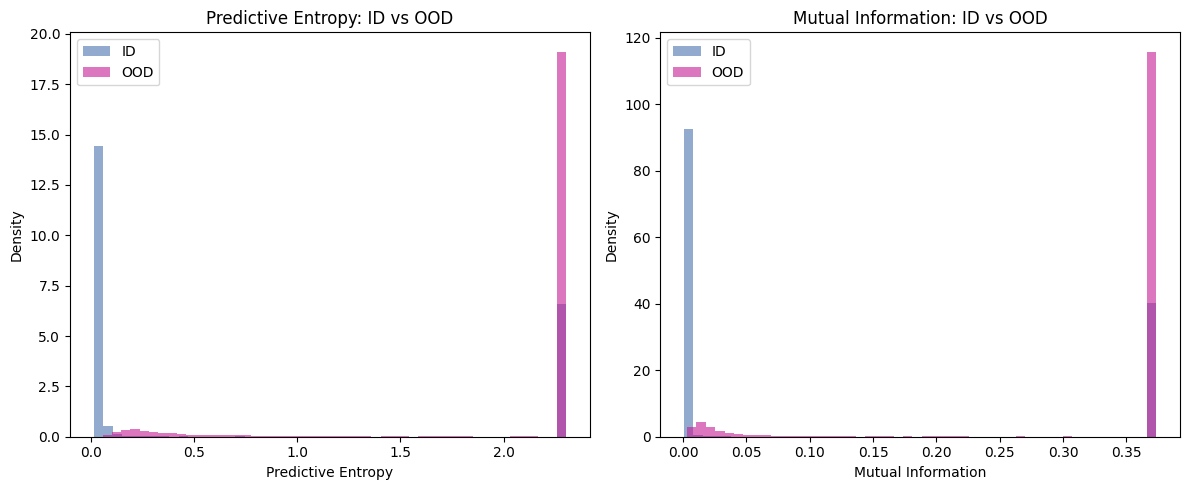

In [17]:
main()

To enhance code reusability and maintain a clean notebook structure, we can get access to the Grayscale-CNN by importing it from the dedicated module.

The same goes for the IRD loss. As seen below, we implement it from train.evidential.torch, which contains all the different losses introduced in the papers.

- **Model Architecture:** Import `GrayscaleMNISTCNN` from `probly.layers.evidential.torch`
- **Loss Function:** Import `IRDLoss` from `probly.train.evidential.torch`  
- **Training Interface:** Use `unified_evidential_train_class` for standardized training

In [ ]:
# ============================================================================
# Advanced: Unified Evidential Training Interface (Optional)
# ============================================================================
# NOTE: Use main() above instead. This is for advanced testing only.
# Uncomment to test the unified training interface:

""""
from src.probly.layers.evidential.torch import GrayscaleMNISTCNN as LibraryGrayscaleMNISTCNN
from src.probly.train.evidential.common import unified_evidential_train
from src.probly.train.evidential.torch import IRDLoss as LibraryLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = get_mnist_dataloaders(batch_size=128)
model = LibraryGrayscaleMNISTCNN(num_classes=10).to(device)
criterion = LibraryLoss(p=2.0, lam=0.01, gamma=0.01)

# Call unified_evidential_train_class with correct parameters
unified_evidential_train(
    mode="IRD",
    model=model,
    dataloader=train_loader,
    loss_fn=criterion,
    epochs=10,
    lr=1e-3,
    device=device,
)
"""

'\nfrom src.probly.layers.evidential.torch import GrayscaleMNISTCNN\nfrom src.probly.train.evidential.common import unified_evidential_train_class\nfrom src.probly.train.evidential.torch import IRDLoss\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\ntrain_loader, val_loader = get_mnist_dataloaders(batch_size=128)\nmodel = GrayscaleMNISTCNN(num_classes=10).to(device)\ncriterion = IRDLoss(p=2.0, lam=0.01, gamma=0.01)\n\n# Call unified_evidential_train_class with correct parameters\nunified_evidential_train_class(\n    mode="IRD",\n    model=model,\n    dataloader=train_loader,\n    loss_fn=criterion,\n    epochs=10,\n    lr=1e-3,\n    device=device,\n)\n'